# Learned Decoder
The purpose of this notebook is to train a CNN to learn the decoded for a Coded Aperture Imaging system

## Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

import wandb
import datetime
desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

from dataset import MNIST_MURA, FashionMURA
from utils.data import load_data
from utils.transforms import Noise_dB, Normalize_01
from reconstruct import RECON_CNN
# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
# Log into WandB for logging project training runs
wandb.login()

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

## Define hyperparameters and load data

In [4]:
# Params dictionary for model params and logging experiments
date = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") #str(datetime.datetime.now().date())
params = {
    "image_size": 23,
    "batch_size":100,
    "learning_rate": 0.001, 
    "epochs": 10,
    "model": f"decoder_cnn_{date}",
    "dataset": "MNIST_mura_noiseless",
    "scheduler_patience": 1,
    "snr": None,
    # "loss": None
}

if params['image_size'] != 23:
    params['model'] = f"decoder_cnn_{date}_{params['image_size']}x{params['image_size']}_{params['dataset']}"
wandb.config = params

# Load data
train_data, test_data, loaders = load_data(params)

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 10
model: decoder_cnn_2024-03-21_16-37-36
dataset: MNIST_mura_noiseless
scheduler_patience: 1
snr: None


TypeError: new() received an invalid combination of arguments - got (Tensor, dtype=torch.dtype), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: dtype
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [ ]:
# Visualize data
fig, axs = plt.subplots(1,2, figsize=(12,7))
idx=0
img = train_data.data[idx]
target = train_data.targets[idx]
sns.heatmap(img, cmap= 'gray', ax=axs[0])
sns.heatmap(target, cmap= 'gray', ax=axs[1])
# axs[0].axis('off')
# axs[1].axis('off')
axs[0].set_title("Training Data")
axs[1].set_title("Target")
# plt.savefig(model.RUN_DIR+'/example.png', dpi=400)
plt.show()

<Axes: ylabel='Count'>

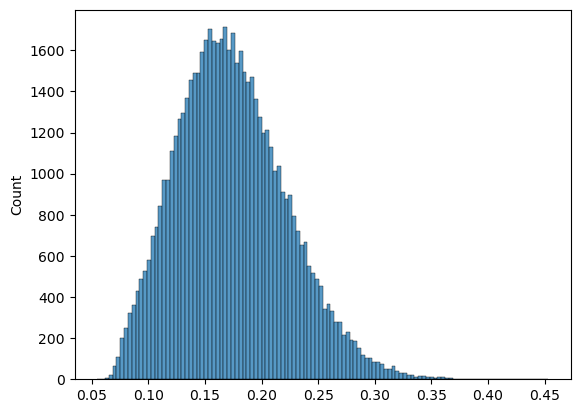

In [5]:
avg_vals = [train_data.data[i].max().item()/train_data.targets[i].max().item() for i in range(len(train_data.data))]
sns.histplot(avg_vals)

<Axes: ylabel='Count'>

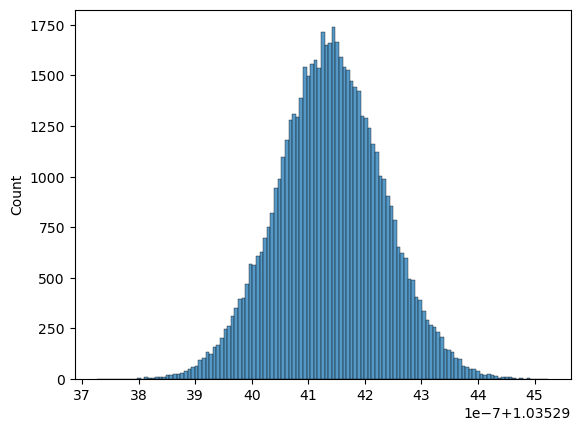

In [6]:
sums = [train_data.data[i].sum().item()/train_data.targets[i].sum().item() for i in range(len(train_data.data))]
sns.histplot(sums)

In [7]:
train_data.G.sum()

tensor(1.)

In [8]:
target.sum()

tensor(72.8431)

In [9]:
img.sum()/train_data.A.sum()

tensor(0.2857)

In [10]:
img.sum()/target.sum()

tensor(1.0353)

# Define Model

In [11]:
# Instantiate model 
model = RECON_CNN(params)#.to(device)
model.apply(model.weights_init)

Using the following parameters:
image_size: 23
batch_size: 100
learning_rate: 0.001
epochs: 10
model: decoder_cnn_2024-03-21_14-41-51
dataset: MNIST_mura_noiseless
scheduler_patience: 1
snr: None
kernel_size: 23
loss: MSELoss()
model_save_path: ../runs/decoder_cnn_2024-03-21_14-41-51/decoder_cnn_2024-03-21_14-41-51.pth


RECON_CNN(
  (criterion): MSELoss()
  (conv): Conv2d(1, 1, kernel_size=(23, 23), stride=(1, 1), padding=same, bias=False, padding_mode=circular)
)

../runs/decoder_cnn_2024-03-21_14-41-51
Initial weights Shape: torch.Size([1, 1, 23, 23])


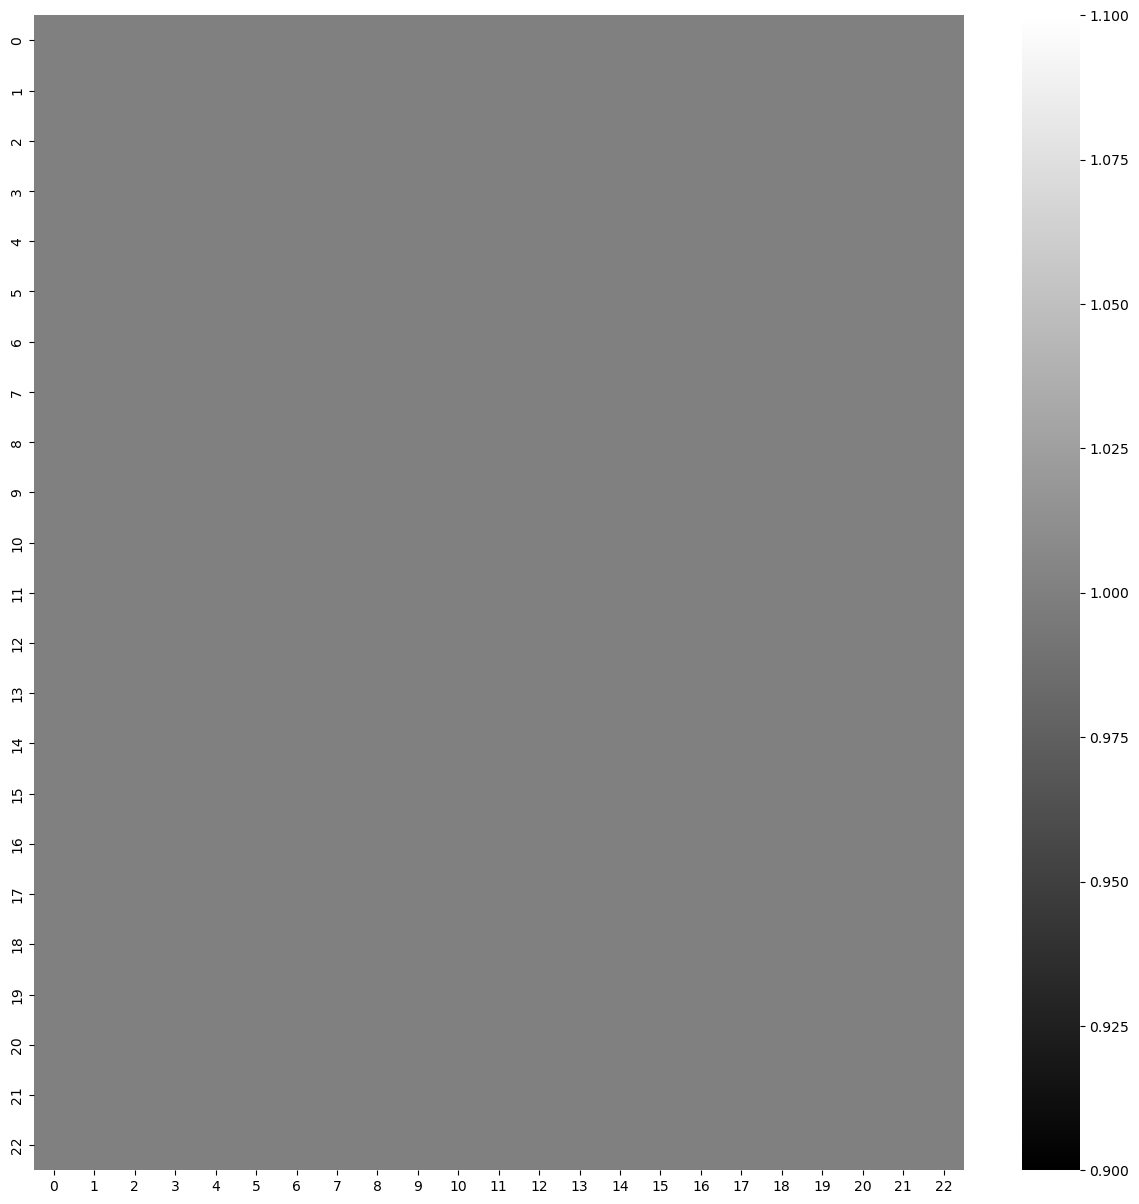

Target weights shape: torch.Size([23, 23])


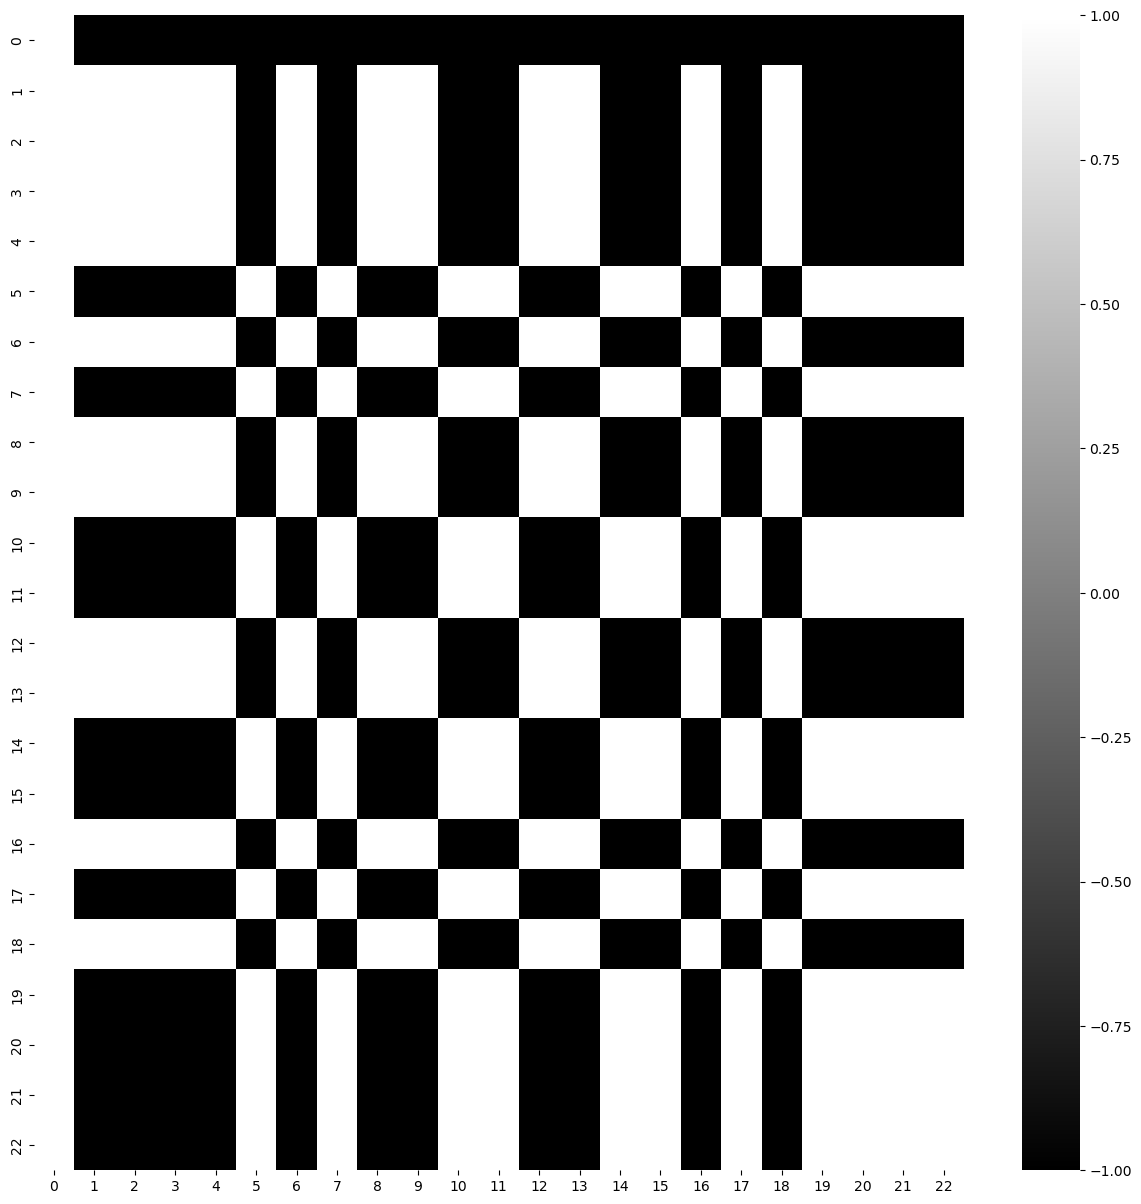

In [12]:
## Plot initial weights
# RUN_DIR = path+f'runs/{model.params["model"]}/'
# if not os.path.exists(RUN_DIR):
#     os.makedirs(RUN_DIR)
print(model.RUN_DIR)
# ----------- Plot initial weights and target weights---- 
# From Jacky's SAR stuff
# Define initial weights from the CNN model
init_weights = list(model.parameters())
init_weight_map = init_weights[0].detach()
print('Initial weights Shape: {}'.format(init_weights[0].shape))

# Plot initial weights
plt.figure(figsize=(15,15))
heat = sns.heatmap(np.squeeze(init_weight_map.cpu().numpy()), cmap='gray')
figure = heat.get_figure()
figure.savefig(model.RUN_DIR+f'/heat_init_weights.png',dpi=400)
#plt.close()
plt.show()

# Define and plot target weights
target_weights = train_data.G
print('Target weights shape: {}'.format(target_weights.shape))
plt.figure(figsize=(15,15))
heat = sns.heatmap(target_weights, cmap='gray')
figure = heat.get_figure()
figure.savefig(model.RUN_DIR+'/heat_target_weights.png',dpi=400)
#plt.close()
plt.show()

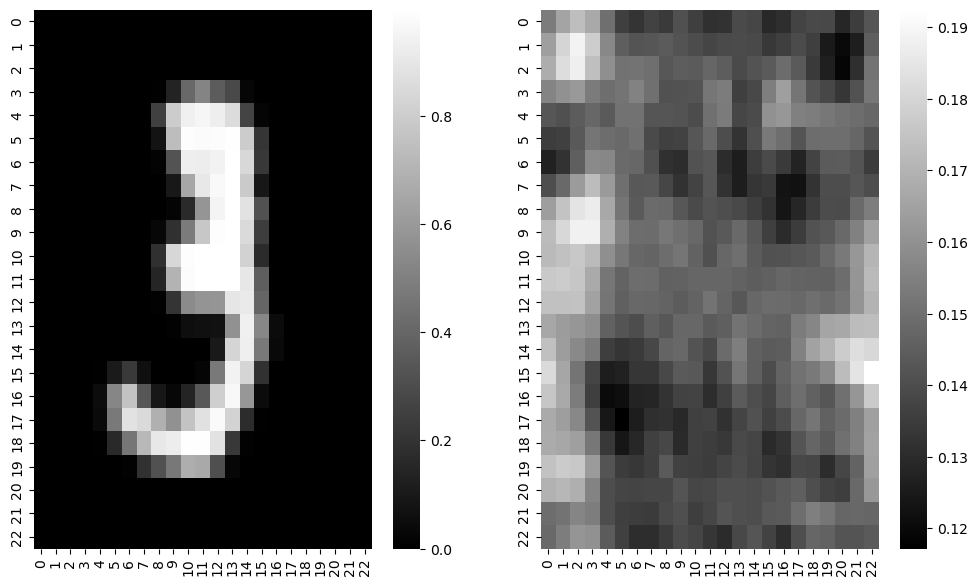

In [13]:
# Visualize data
fig, axs = plt.subplots(1,2, figsize=(12,7))
idx=10
sns.heatmap(loaders['train'].dataset[idx]['target'].squeeze(0), cmap= 'gray', ax=axs[0])
sns.heatmap(loaders['train'].dataset[idx]['img'].squeeze(0), cmap= 'gray', ax=axs[1])
# axs[0].axis('off')
# axs[1].axis('off')
plt.savefig(model.RUN_DIR+'/example.png', dpi=400)
plt.show()

# Training

Epoch: 0, batch 1
Epoch: 0, batch 2
Epoch: 0, batch 3
Epoch: 0, batch 4
Epoch: 0, batch 5
Epoch: 0, batch 6
Epoch: 0, batch 7
Epoch: 0, batch 8
Epoch: 0, batch 9
Epoch: 0, batch 10
Epoch: 0, batch 11
Epoch: 0, batch 12
Epoch: 0, batch 13
Epoch: 0, batch 14
Epoch: 0, batch 15
Epoch: 0, batch 16
Epoch: 0, batch 17
Epoch: 0, batch 18
Epoch: 0, batch 19
Epoch: 0, batch 20
Epoch: 0, batch 21
Epoch: 0, batch 22
Epoch: 0, batch 23
Epoch: 0, batch 24
Epoch: 0, batch 25
Epoch: 0, batch 26
Epoch: 0, batch 27
Epoch: 0, batch 28
Epoch: 0, batch 29
Epoch: 0, batch 30
Epoch: 0, batch 31
Epoch: 0, batch 32
Epoch: 0, batch 33
Epoch: 0, batch 34
Epoch: 0, batch 35
Epoch: 0, batch 36
Epoch: 0, batch 37
Epoch: 0, batch 38
Epoch: 0, batch 39
Epoch: 0, batch 40
Epoch: 0, batch 41
Epoch: 0, batch 42
Epoch: 0, batch 43
Epoch: 0, batch 44
Epoch: 0, batch 45
Epoch: 0, batch 46
Epoch: 0, batch 47
Epoch: 0, batch 48
Epoch: 0, batch 49
Epoch: 0, batch 50
Epoch: 0, batch 51
Epoch: 0, batch 52
Epoch: 0, batch 53
Ep

/Users/jornelasmunoz/anaconda3/envs/pytorch/lib/python3.11/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Users/jornelasmunoz/anaconda3/envs/pytorch/lib/python3.11/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Epoch: 1, batch 0
Epoch: 1, batch 1
Epoch: 1, batch 2
Epoch: 1, batch 3
Epoch: 1, batch 4
Epoch: 1, batch 5
Epoch: 1, batch 6
Epoch: 1, batch 7
Epoch: 1, batch 8
Epoch: 1, batch 9
Epoch: 1, batch 10
Epoch: 1, batch 11
Epoch: 1, batch 12
Epoch: 1, batch 13
Epoch: 1, batch 14
Epoch: 1, batch 15
Epoch: 1, batch 16
Epoch: 1, batch 17
Epoch: 1, batch 18
Epoch: 1, batch 19
Epoch: 1, batch 20
Epoch: 1, batch 21
Epoch: 1, batch 22
Epoch: 1, batch 23
Epoch: 1, batch 24
Epoch: 1, batch 25
Epoch: 1, batch 26
Epoch: 1, batch 27
Epoch: 1, batch 28
Epoch: 1, batch 29
Epoch: 1, batch 30
Epoch: 1, batch 31
Epoch: 1, batch 32
Epoch: 1, batch 33
Epoch: 1, batch 34
Epoch: 1, batch 35
Epoch: 1, batch 36
Epoch: 1, batch 37
Epoch: 1, batch 38
Epoch: 1, batch 39
Epoch: 1, batch 40
Epoch: 1, batch 41
Epoch: 1, batch 42
Epoch: 1, batch 43
Epoch: 1, batch 44
Epoch: 1, batch 45
Epoch: 1, batch 46
Epoch: 1, batch 47
Epoch: 1, batch 48
Epoch: 1, batch 49
Epoch: 1, batch 50
Epoch: 1, batch 51
Epoch: 1, batch 52
Epo

KeyboardInterrupt: 

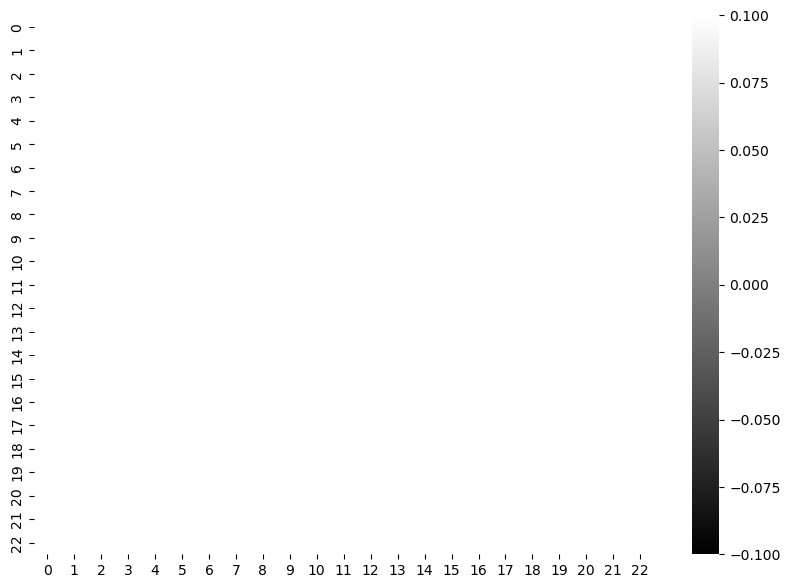

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x1648ee990>> (for post_run_cell), with arguments args (<ExecutionResult object at 16b81f510, execution_count=14 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 16ae2fd90, raw_cell="%%time
# Initialize project in Weights and Biases
.." store_history=True silent=False shell_futures=True cell_id=3c876fc9-e3d7-4489-a0b8-d06922820f1e> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [14]:
%%time
# Initialize project in Weights and Biases
wandb.init(config=wandb.config, 
           project="ca-learned-decoder", 
           group=f"cnn_{params['image_size']}x{params['image_size']}", 
           name=str(datetime.datetime.now()))

# Store values for later 
train_loss = []
frob_per_epoch = []
weights_epoch = {}

#Dictionary that will store different images and outputs for various epochs (not sure if needed)
outputs = {}

# Training loop starts
for epoch in range(params['epochs']):
    
    # Initialize variable to store loss
    running_loss = 0
    model.train()
    # Iterate over training set
    for i, data in enumerate(loaders['train']):
        # zero the parameter gradients
        model.optimizer.zero_grad()
        
        # get the inputs; data is a dict of [images, labels, digit]
        inputs, targets, digits = data['img'], data['target'], data['digit']
            
        # Generate output
        out = model(inputs)
        
        # Calculate loss
        loss = model.criterion(out, targets)
        
        # # Modified (04/06/23) to include l_1 penalty
        # l_1_pen = sum((w.abs()-1).abs().sum() for w in model.parameters())
        # loss = loss + (model.params['lambda']/(model.params['p']**2)) * l_1_pen

        weights = list(model.parameters())
        weight_map = np.squeeze(weights[0].detach().cpu().numpy())
        if np.isnan(weight_map).any():
            print("Epoch: {}, batch {}".format(epoch, i))
        
        # Backprop and update weights
        loss.backward()
        model.optimizer.step()
        
        # Increment loss
        running_loss += loss.item()
        
        
        
    # Average loss over entire dataset
    running_loss/= len(loaders['train'].dataset)#params['batch_size']
    train_loss.append(running_loss)

    # Scheduler step every epoch
    model.scheduler.step(loss)
        
    print(f"Epoch {epoch +1} | Loss: {running_loss:.7f}")
    wandb.log({"epoch": epoch, "loss": running_loss, }) 
    
    # Storing images, reconstructed outputs, and labels
    outputs[epoch+1] = {'img': inputs, 'out': out, 'targets': targets, 'digits': digits}
    
    # Save weights every 2 epochs
    if epoch % 2 == 1:
        torch.save(model.state_dict(), model.params['model_save_path'])
        # epoch_save_model = path+f'models/CNN/{params["model"]}_model_epoch_'+str(epoch)+'.pth'
        # torch.save(model.state_dict(),epoch_save_model)
        weight_epoch_list = list(model.parameters())
        weights_epoch[f'{epoch}'] = np.squeeze(weight_epoch_list[0].detach().cpu().numpy())
        

    # Calculate Frobenius norm between weights and decoder every epoch
    weights = list(model.parameters())
    weight_map = np.squeeze(weights[0].detach().cpu().numpy())
    diff_block = train_data.G - weight_map
    frob_per_epoch.append(np.linalg.norm(np.abs(diff_block),ord='fro'))
    fig, axs = plt.subplots(1,1, figsize=(10,7))
    sns.heatmap(weight_map, cmap='gray', ax=axs)
    fig.savefig(os.path.join(model.RUN_DIR,f'weights_epoch{epoch+1}.png'),dpi=400)
    # weight_heatmap = sns.heatmap(weight_map, cmap='gray')
    # figure = weight_heatmap.get_figure()
    # figure.savefig(model.RUN_DIR+f'weights_epoch{epoch+1}.png',dpi=400)
#torch.save(model.state_dict(), PATH)
# End WandB run
wandb.finish()

In [15]:
wandb.finish()

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x1648ee990>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 16b89e750, raw_cell="wandb.finish()" store_history=True silent=False shell_futures=True cell_id=c2120292-291e-4eb7-b26f-07541ed477da>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

epoch,▁
epoch,0
loss,nan


In [9]:
# Save model weights from last epoch
torch.save(model.state_dict(), model.params['model_save_path'])

# Save weight progression
dict_path = model.RUN_DIR+'/weights_epoch.pkl'

import pickle
# Save weights dictionary to file
with open(dict_path, 'wb') as pickle_file:
    pickle.dump(weights_epoch, pickle_file)
print(f'Dictionary saved to {dict_path}')

# save frobenius per epoch
with open(model.RUN_DIR+'/frob_per_epoch.pkl', 'wb') as pickle_file:
    pickle.dump(frob_per_epoch, pickle_file)
print(f'Frobenius saved to {model.RUN_DIR+"/frob_per_epoch.pkl"}')

Dictionary saved to ../runs/decoder_cnn_2024-03-21_14-18-55/weights_epoch.pkl
Frobenius saved to ../runs/decoder_cnn_2024-03-21_14-18-55/frob_per_epoch.pkl


# Load model

In [11]:
# model.load_state_dict(torch.load('../models/learned_decoder_cnn/decoder_cnn.pth'))
# model.load_state_dict(torch.load(model.RUN_DIR+f"{model.params['model']}.pth"))

In [12]:
weight_map = list(model.parameters())[0].cpu().detach().squeeze(0).squeeze(0)

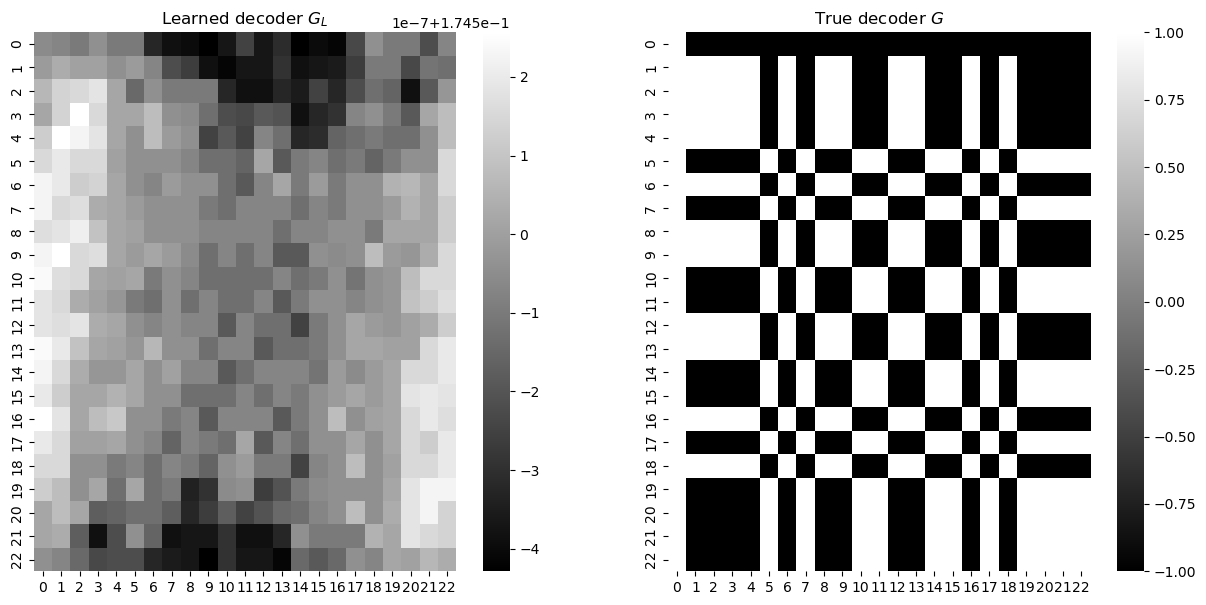

In [17]:
fig, axs = plt.subplots(1,2, figsize = (15,7))
sns.heatmap(weight_map, cmap='gray', ax=axs[0])
sns.heatmap(train_data.G, cmap='gray', ax=axs[1])

axs[0].set_title("Learned decoder $G_L$")
axs[1].set_title("True decoder $G$")
# fig.savefig('../figs/learned_decoder_cnn_47x47_20_epochs_circular_pad.png')
fig.savefig(model.RUN_DIR+'/heat_learned_weights.png',dpi=400)
plt.show()

# Test set evaluation

In [14]:
from torchmetrics.image import StructuralSimilarityIndexMeasure 

In [21]:
SSIM = StructuralSimilarityIndexMeasure()

In [23]:
model.params['snr'] = 'noiseless'
# Define transforms 
transform_list = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize(params['image_size'], antialias=True),
                # Noise_dB(desired_snr=model.params['snr']),
                # transforms.Normalize(0, 1),
                Normalize_01(),
                ])
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                Normalize_01(),
                ])

# Define test set
# test_mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=transform_list, target_transform=target_transform, train=False)
test_mura = FashionMURA('../data/FashionMNIST/', params, transform=transform_list, target_transform=target_transform, train=False)
testset = DataLoader(test_mura, batch_size=100, shuffle=True)

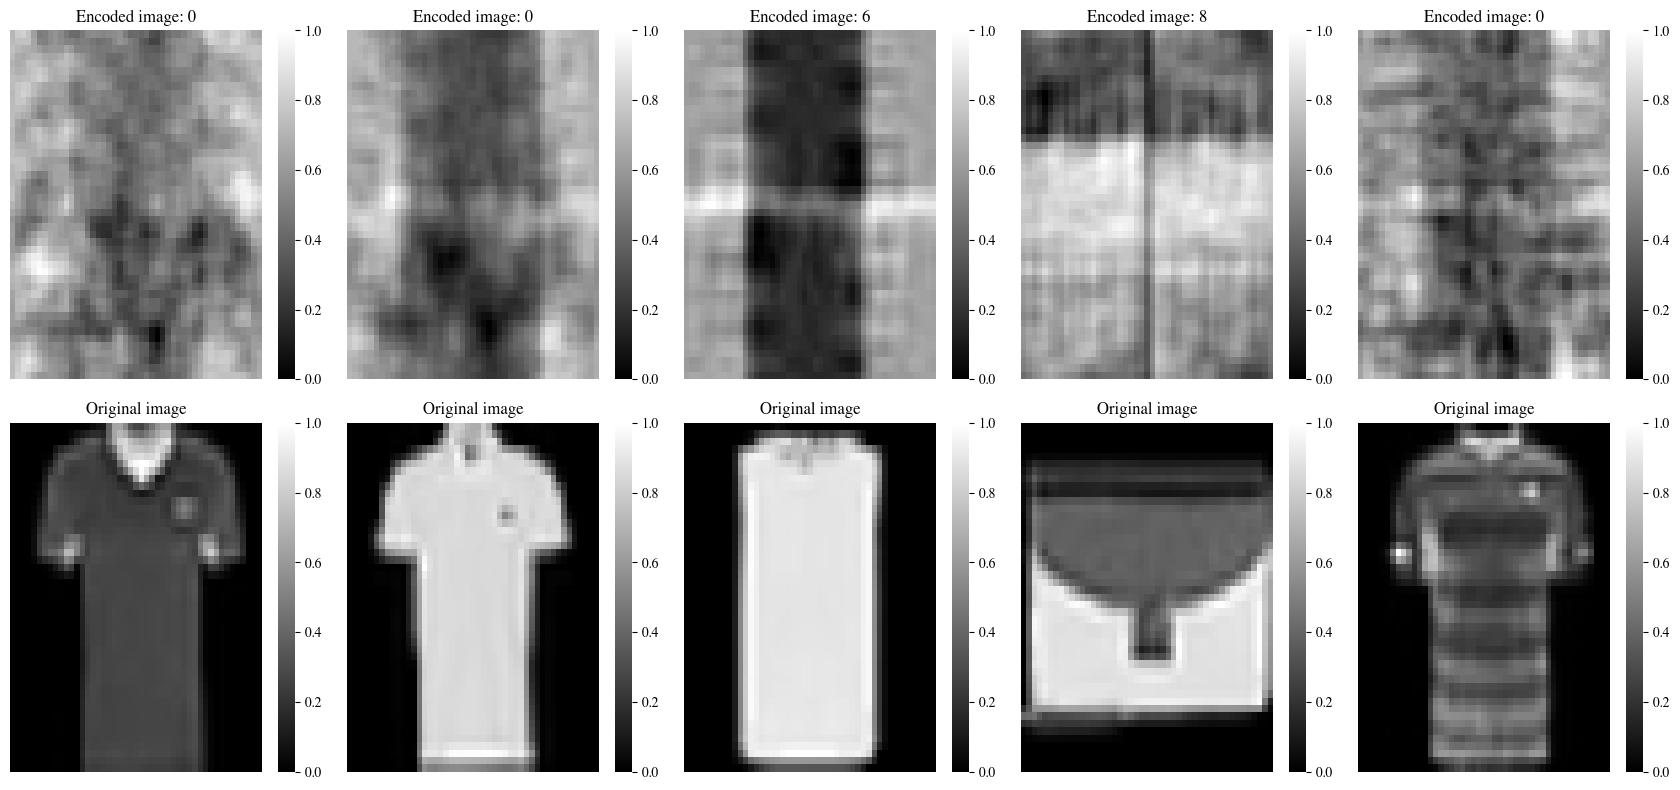

In [25]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [17,8],
})
# Printing 25 random images from the test dataset
random_samples = np.random.randint(1, len(testset), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(testset.dataset[idx]['img'].squeeze(0), cmap='gray')
    plt.title(f'Encoded image: {testset.dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(testset.dataset[idx]['target'].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
plt.savefig(model.RUN_DIR+ f"encoded_examples_snr_{model.params['snr']}.png")
plt.show()

In [26]:
results = []
for i, data in enumerate(testset):
    inputs, targets, digits = data['img'], data['target'], data['digit']
    outputs = model(inputs.to(device))
    mse_loss = model.criterion(outputs, targets)
    ssim_loss = SSIM(outputs, targets)
    results.append((inputs, outputs, targets, digits, mse_loss.item(), ssim_loss.item()))
    # show_outputs(outputs, targets, inputs, iterator=i)

In [27]:
df = pd.DataFrame(results, columns=['inputs', 'outputs', 'targets', 'digits', 'mse', 'ssim'])

In [28]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
# pio.renderers.default = 'notebook'

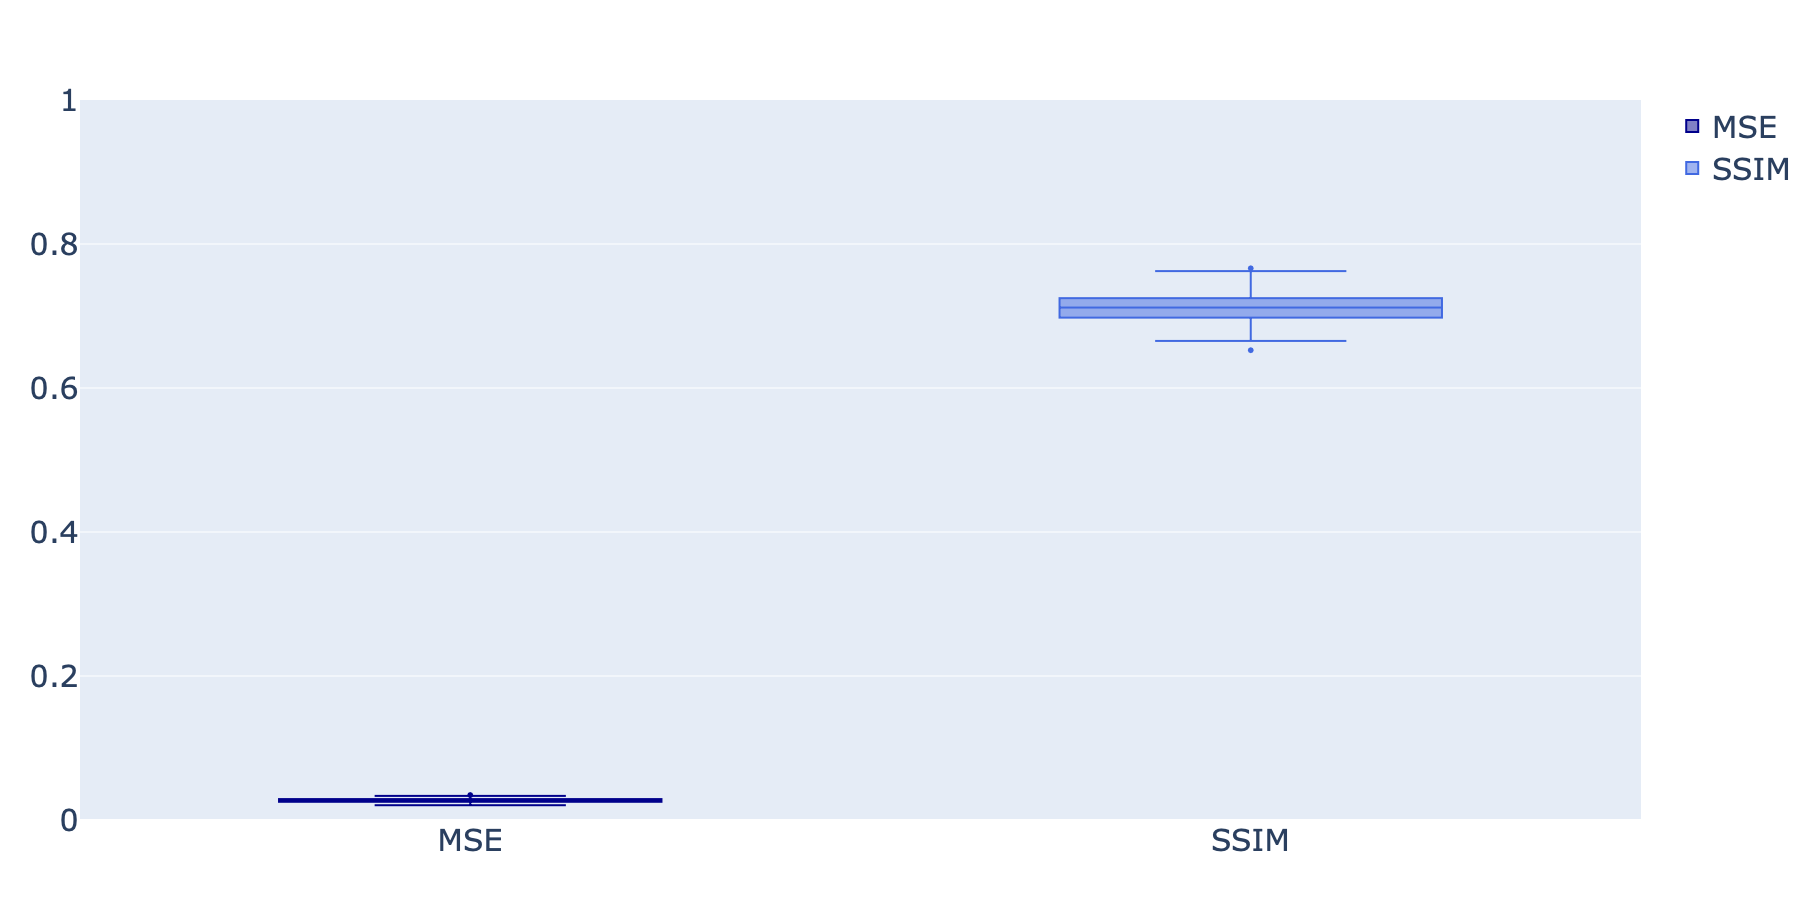

In [29]:
y0 = df.mse
y1 = df.ssim

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='MSE',
                marker_color = 'darkblue'))
fig.add_trace(go.Box(y=y1, name = 'SSIM',
                marker_color = 'royalblue'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        tickmode="array",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
)
fig.show(renderer="jupyterlab")
fig.write_image(model.RUN_DIR + f'boxplot_metrics_snr_{model.params["snr"]}.png')

# Rotate the weights

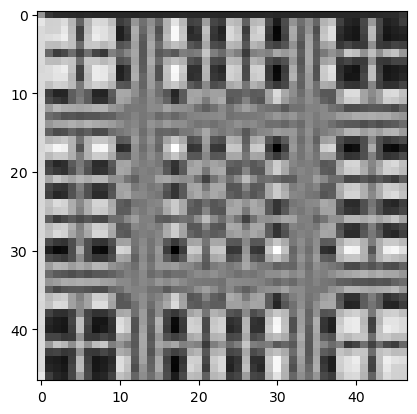

In [10]:
# Rotate the weights 180 degrees
w_rot90 = torch.rot90(torch.Tensor(weight_map), 1, [0, 1])
w_rot180 = torch.rot90(w_rot90, 1, [0, 1])
plt.imshow(w_rot180, cmap='gray')

In [12]:
np.linalg.norm(np.abs(w_rot180 - train_data.G),ord='fro')

46.22061846670332

In [14]:
pad = params['image_size']//2
padded_ex = torch.nn.functional.pad(loaders['train'].dataset[idx]['target'].unsqueeze(0), pad=(pad,pad,pad,pad), mode='circular')
padded_ex = padded_ex.squeeze(0).squeeze(0)

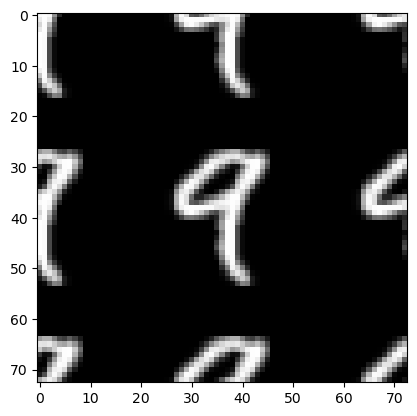

In [15]:
plt.imshow(padded_ex, cmap='gray')
plt.show()

# To be deleted

In [5]:
from tqdm import tqdm

In [7]:
##### COMPUTE PIXEL SUM AND SQUARED SUM

# placeholders
psum    = torch.tensor([0.0])
psum_sq = torch.tensor([0.0])

# loop through images
for inputs in tqdm(loaders['train']):
    img, target, digits = inputs.values()
    psum    += img.sum()
    psum_sq += (img ** 2).sum()

100%|████████████████████████████████████████| 600/600 [00:01<00:00, 365.19it/s]


In [8]:
# pixel count
count = len(loaders['train']) * params['image_size'] * params['image_size']

# mean and STD
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('Training data stats:')
print('- mean: {:.4f}'.format(total_mean.item()))
print('- std:  {:.4f}'.format(total_std.item()))

Training data stats:
- mean: 344.8359
- std:  nan


In [12]:
print("Target min {:.1f} | max {:.1f}".format(target.min(), target.max()))
print("Image min {:.1f} | max {:.1f}".format(img.min(), img.max()))

Target min 0.0 | max 0.5
Image min 14.6 | max 23.3


In [13]:
img.max()/target.max()

tensor(46.0593)

In [14]:
train_data.A.sum()

tensor(264.)

In [15]:
min_vals = [train_data.data[i].min().item() for i in range(len(train_data.data))]
max_vals = [train_data.data[i].max().item() for i in range(len(train_data.data))]

<Axes: ylabel='Count'>

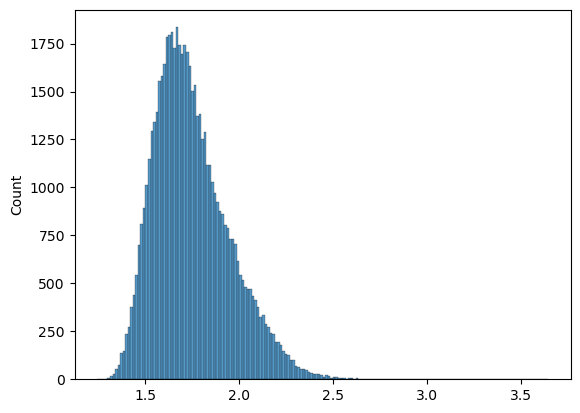

In [7]:
avg_vals = [train_data.data[i].max().item()/train_data.data[i].min().item() for i in range(len(train_data.data))]
sns.histplot(avg_vals)

In [9]:
np.mean(max_vals)/(23*23)

0.04215248952415204

<Axes: ylabel='Count'>

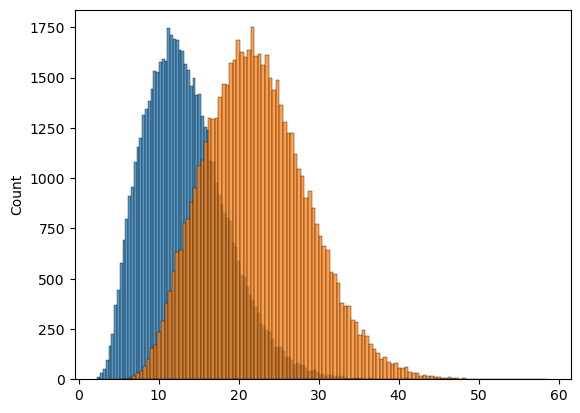

In [10]:
sns.histplot(min_vals)
sns.histplot(max_vals)